In [18]:
# Generate the data
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import trange
from pathlib import Path
import matplotlib.pyplot as plt       # histograms, QQ plots, etc.
import pickle


def generate_xy_equally_spaced(n=10000):
    random.seed(42) 

    x = np.linspace(0, 1, n)
    random.shuffle(x)  # shuffle the x values to ensure randomness
    # y = np.exp(x)
    y = x**2
    return x, y


In [19]:
# model (TensorFlow 2 / Keras)
def make_model(seed=None):
    if seed is not None:
        tf.random.set_seed(seed)
    

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=["mae"])
    return model


In [22]:
# Training
def train_many(n_runs=1000, n_samples=10000, epochs=100, inverse=False):
    weight_rows, bias_rows, error_all = [], [], []
    
    bar = trange(
        n_runs,
        desc="Inverse runs" if inverse else "Forward runs",
        unit="run"
    )
    
    for seed in bar:                    
        tf.keras.backend.clear_session()

        x, y = generate_xy_equally_spaced(n_samples)
        if inverse:
            x, y = y, x
            
    # for seed in trange(n_runs, desc=f"{'Inverse' if inverse else 'Forward'} runs"):
    #     tf.keras.backend.clear_session()
    #     x, y = generate_xy_equally_spaced(n_samples)
    #     if inverse:
    #         x, y = y, x

        split = int(0.8 * n_samples)
        x_train, x_test = x[:split], x[split:]
        y_train, y_test = y[:split], y[split:]
        
# --- build the model ---
        model = make_model(seed = seed)
        # print(f"Training model with seed {seed} on {n_samples} samples for {epochs} epochs")
        model.fit(x_train, y_train, epochs=epochs, verbose=0)

# ----- collect weights & biases
        w_vec, b_vec = [], []  # this line is inside the for-loop, so it is reset each run
        for layer in model.layers:
            W, b = layer.get_weights()
            w_vec.extend(W.flatten())
            b_vec.extend(b.flatten()) # ← only one value per loop

        weight_rows.append(w_vec)
        bias_rows.append(b_vec)
        
# ----- evaluate & store only the loss 
        # loss_value = float(model.evaluate(x_test, y_test, verbose=0))
        # error_all.append(loss_value)
        
        test_metrics = model.evaluate(x_test, y_test, verbose=0)
        loss_value   = test_metrics[0] if isinstance(test_metrics, (list, tuple, np.ndarray)) else test_metrics
        error_all.append(float(loss_value))
        
        # put a quick status on the bar instead of printing
        bar.set_postfix(seed=seed, mse=f"{loss_value:.3e}")
        
    return (
        pd.DataFrame(weight_rows), 
        pd.DataFrame(bias_rows), 
        pd.Series(error_all, name="MSE")
    )


In [23]:
# Run experiments & save
OUT = Path("nn_distributions"); OUT.mkdir(exist_ok=True)

w_fwd, b_fwd, error_fwd = train_many(n_runs=100, inverse=False)
#w_inv, b_inv = train_many(n_runs=10000, inverse=True)

for name, df in [("weights_fwd", w_fwd), 
                 ("biases_fwd", b_fwd), 
                 ("errors_fwd", error_fwd)]:
                 #("weights_inv", w_inv), 
                 #("biases_inv", b_inv)
                
    with open(OUT / f"{name}.pkl", "wb") as f:
        pickle.dump(df, f)

print("[✓] Pickle files written in", OUT.resolve())
print(error_fwd[:5])            # see first 5 numbers



Forward runs: 100%|██████████| 100/100 [1:23:19<00:00, 49.99s/run, mse=3.179e-05, seed=99]

[✓] Pickle files written in C:\Users\Stu_PP\Downloads\nn_distributions
0    0.000031
1    0.000032
2    0.000033
3    0.000033
4    0.000031
Name: MSE, dtype: float64


In [24]:
# Load the pickle files
weights_df = pickle.load(open(OUT / "weights_fwd.pkl", "rb"))
biases_df  = pickle.load(open(OUT / "biases_fwd.pkl", "rb"))
error_df = pickle.load(open(OUT / "errors_fwd.pkl", "rb"))   # <- this is a Series

# Rename columns
weights_df.columns = [f"w{i}" for i in range(weights_df.shape[1])]
biases_df.columns  = [f"b{i}" for i in range(biases_df.shape[1])]

# Combine everything horizontally
combined_df = pd.concat([weights_df,
                         biases_df,
                         error_df.rename("error")],  # single MSE column
                        axis=1)

# print(combined_df.head()) 
combined_df.head()

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,b2,b3,b4,b5,b6,b7,b8,b9,b10,error
0,-2.462665,2.375923,-1.863519,-1.938985,2.274850,1.961483,1.883556,-1.267099,0.909105,-0.944004,...,-0.372867,-0.158606,-0.299322,0.133155,-0.088452,0.125706,-0.286930,0.370943,0.323009,0.000031
1,-2.436477,2.353000,-1.861736,-1.944551,2.314904,1.941360,1.871724,-1.261334,0.912653,-0.943283,...,-0.346716,-0.144413,-0.279428,0.137282,-0.088549,0.122350,-0.288749,0.373116,0.324142,0.000032
2,-2.429262,2.370882,-1.837044,-1.927007,2.339395,1.908180,1.847519,-1.239189,0.901010,-0.927791,...,-0.316624,-0.131774,-0.257518,0.148578,-0.091223,0.113089,-0.298148,0.381150,0.331487,0.000033
3,-2.447761,2.369424,-1.853885,-1.939007,2.304649,1.949799,1.876771,-1.267615,0.908422,-0.941820,...,-0.353914,-0.152294,-0.275308,0.137583,-0.087770,0.122743,-0.289609,0.372896,0.324705,0.000033
4,-2.427759,2.350411,-1.851270,-1.940127,2.314917,1.929819,1.863107,-1.252465,0.907660,-0.938352,...,-0.335652,-0.142808,-0.277176,0.140870,-0.088985,0.120436,-0.292523,0.377421,0.328031,0.000031


<Axes: title={'center': 'w0'}, ylabel='Frequency'>

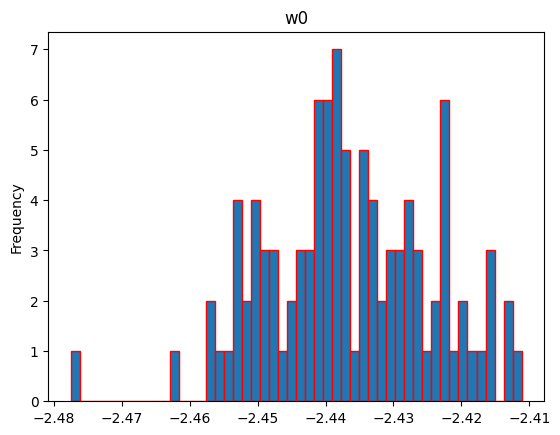

In [25]:
weights_df['w0'].plot.hist(bins=50, title='w0', edgecolor='red')

<Axes: title={'center': 'b0'}, ylabel='Frequency'>

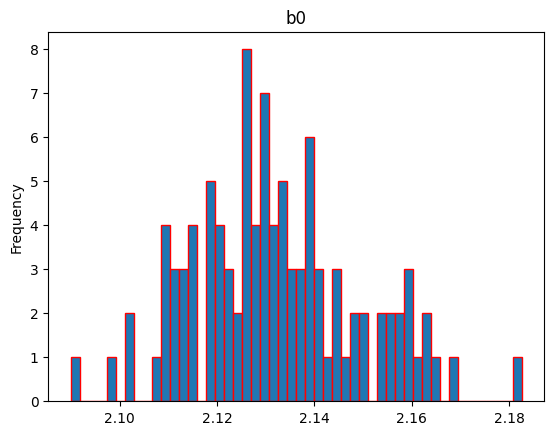

In [26]:
biases_df['b0'].plot.hist(bins=50, title='b0', edgecolor='red')

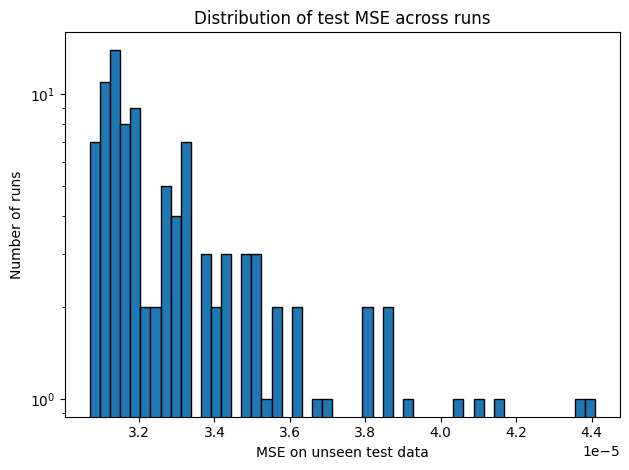

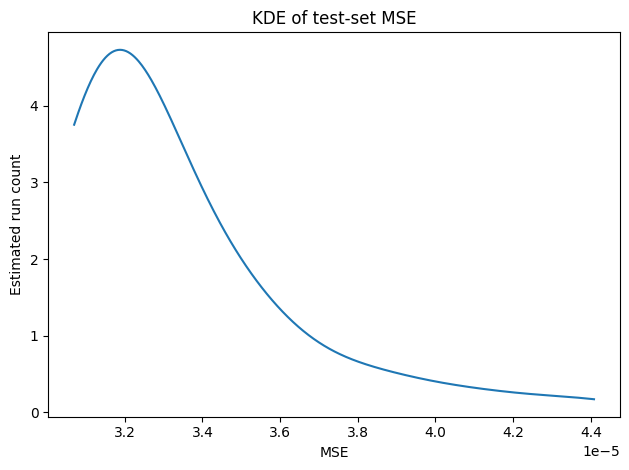

In [28]:
from scipy.stats import gaussian_kde

# Load your error-series
# OUT = Path("nn_distributions")
err_path = OUT / "errors_fwd.pkl"
mse_list = pickle.load(open(err_path, "rb"))
mse = np.array([float(np.squeeze(v)) for v in mse_list])

# Plot histogram (with log-scaled y-axis)
plt.figure()
counts, bins, patches = plt.hist(
    mse,
    bins=50,
    edgecolor='black',
    density=False
)
plt.yscale("log")
plt.xlabel("MSE on unseen test data")
plt.ylabel("Number of runs")
plt.title("Distribution of test MSE across runs")
plt.tight_layout()
plt.show()

# Overlay a KDE using SciPy if you have it:
try:
    from scipy.stats import gaussian_kde

    kde = gaussian_kde(mse, bw_method=0.5)
    x_vals = np.linspace(mse.min(), mse.max(), 500)
    # scale the KDE so its area matches the histogram
    scale = len(mse) * (bins[1] - bins[0])
    plt.figure()
    plt.plot(x_vals, kde(x_vals) * scale)
    plt.xlabel("MSE")
    plt.ylabel("Estimated run count")
    plt.title("KDE of test-set MSE")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("SciPy not installed; skipping KDE overlay.")

In [11]:
import seaborn as sns

# Load the test-losses (MSE)
err_path = OUT / "errors_fwd.pkl"
err_object = pickle.load(open(err_path, "rb"))

mse = pd.Series(err_object).apply(
    lambda v: float(np.squeeze(v))     # flatten & cast
).to_numpy()                           # → simple NumPy array

print("Test-set MSE across runs:")
print(pd.Series(mse).describe().to_string(float_format="%.6g"))


plt.figure()
plt.hist(
    mse,
    bins=50,
    edgecolor='black'
)
plt.yscale("log")
plt.xlabel("MSE on unseen test data")
plt.ylabel("Number of runs")
plt.title("Distribution of test MSE across 10 runs")   # adjust “10” if you run more
plt.tight_layout()
plt.show()

# save the figure alongside your pickles
# plt.savefig(OUT / "mse_histogram.png", dpi=300)
sns.kdeplot(mse, bw_adjust=0.5)


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
test_points = np.array([
    [np.pi/2],         # f(π/2)
    [np.sqrt(2)/2],    # f(√2 / 2)
])
preds = model.predict(test_points)
for x_val, y_hat in zip(test_points.flatten(), preds.flatten()):
    print(f"f({x_val:.4f}) ≈ {y_hat:.6f}")

In [ ]:
xs = np.linspace(0, 2*np.pi, 100)[:,None]
ys = model.predict(xs)

# Headinig

>this is my code


$RMSE = \sum (y-\hat{y})^2$